In [1]:
%cd /Users/masha/Documents/GSOC/GSoC-Quantum-Diffusion-Model

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

import matplotlib.pyplot as plt
import h5py
import scipy.linalg
import math

/Users/masha/Documents/GSOC/GSoC-Quantum-Diffusion-Model


In [2]:
filename = "data/QG1_64x64_1k"
data_X = np.array(h5py.File(filename, "r")['X'])

print("Raw data shape:", data_X.shape)

data_X = data_X.astype(np.float32)

# log + normalize
data_X = np.log1p(data_X)
data_X = data_X / data_X.max()

# map to [-1, 1]
data_X = 2.0 * data_X - 1.0

Raw data shape: (1000, 64, 64)


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

tensor_data = torch.tensor(data_X).unsqueeze(1)  # (N, 1, 64, 64)
dataset = TensorDataset(tensor_data)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

print("Tensor data shape:", tensor_data.shape)

Tensor data shape: torch.Size([1000, 1, 64, 64])


In [4]:
class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.lin = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.SiLU(),
            nn.Linear(dim * 4, dim)
        )

    def forward(self, t):
        half = self.dim // 2
        freqs = torch.exp(
            -math.log(10000) * torch.arange(0, half, device=t.device) / half
        )
        args = t.unsqueeze(-1) * freqs.unsqueeze(0)
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
        return self.lin(emb)


class SmallConvField(nn.Module):
    def __init__(self, in_ch=1, base_ch=64, time_emb_dim=64):
        super().__init__()
        self.time_emb = TimeEmbedding(time_emb_dim)
        self.time_proj = nn.Linear(time_emb_dim, base_ch)

        self.init_conv = nn.Conv2d(in_ch + 1, base_ch, 3, padding=1, padding_mode='circular')
        self.conv1 = nn.Conv2d(base_ch, base_ch, 3, padding=1, padding_mode='circular')
        self.conv2 = nn.Conv2d(base_ch, base_ch, 3, padding=1, padding_mode='circular')

        self.mid = nn.Sequential(
            nn.Conv2d(base_ch, base_ch, 3, padding=1, padding_mode='circular'),
            nn.SiLU(),
            nn.Conv2d(base_ch, base_ch, 3, padding=1, padding_mode='circular'),
            nn.SiLU()
        )

        self.final = nn.Sequential(
            nn.Conv2d(base_ch, base_ch, 3, padding=1, padding_mode='circular'),
            nn.SiLU(),
            nn.Conv2d(base_ch, in_ch, 3, padding=1, padding_mode='circular')
        )

    def forward(self, x, t):
        B, C, H, W = x.shape
        t_channel = t.view(B, 1, 1, 1).expand(-1, 1, H, W)
        h = torch.cat([x, t_channel], dim=1)

        h = F.silu(self.init_conv(h))
        h = F.silu(self.conv1(h) + h)
        h = F.silu(self.conv2(h) + h)

        h = self.mid(h)

        t_emb = self.time_emb(t)
        t_proj = self.time_proj(t_emb).view(B, -1, 1, 1)
        h = h + t_proj

        return self.final(h)

def linear_mix(x0, x1, t):
    t = t.view(-1, 1, 1, 1)
    return (1.0 - t) * x0 + t * x1

In [62]:
def make_radius_map(H, W, device):
    yy, xx = torch.meshgrid(
        torch.arange(H, device=device),
        torch.arange(W, device=device),
        indexing="ij"
    )
    cy, cx = (H - 1) / 2.0, (W - 1) / 2.0
    r = torch.sqrt((yy - cy)**2 + (xx - cx)**2)
    return r

def radial_profile(x, radius_map, n_bins=32):
    """
    x: (B, 1, H, W)
    returns: (B, n_bins)
    """
    B, _, H, W = x.shape
    r = radius_map.view(1, -1)           # (1, H*W)
    x_flat = x.view(B, -1)               # (B, H*W)

    r_max = r.max()
    bins = torch.linspace(0, r_max, n_bins + 1, device=x.device)

    profiles = []
    for i in range(n_bins):
        mask = (r >= bins[i]) & (r < bins[i+1])
        mask = mask.float()
        energy = (x_flat * mask).sum(dim=1)
        norm = mask.sum() + 1e-6
        profiles.append(energy / norm)

    return torch.stack(profiles, dim=1)

def radial_loss(x_real, x_fake, radius_map, n_bins=32):
    real_prof = radial_profile(x_real, radius_map, n_bins)
    fake_prof = radial_profile(x_fake, radius_map, n_bins)
    return F.mse_loss(fake_prof, real_prof)

def energy_centroid(x):
    """
    x: (B, 1, H, W)
    returns: (B, 2)  (y, x)
    """
    B, _, H, W = x.shape

    yy, xx = torch.meshgrid(
        torch.arange(H, device=x.device),
        torch.arange(W, device=x.device),
        indexing="ij"
    )

    energy = x.squeeze(1)
    energy_sum = energy.sum(dim=(1,2)) + 1e-6

    cy = (energy * yy).sum(dim=(1,2)) / energy_sum
    cx = (energy * xx).sum(dim=(1,2)) / energy_sum

    return torch.stack([cy, cx], dim=1)

def centroid_loss(x_real, x_fake):
    c_real = energy_centroid(x_real)
    c_fake = energy_centroid(x_fake)
    return F.mse_loss(c_fake, c_real)

def radial_weighted_mix(x0, x1, t, radius_map, r_scale=20.0):
    """
    x0: (B,1,H,W) real jet
    x1: (B,1,H,W) noise
    t:  (B,) in [0,1]
    radius_map: (H,W)
    r_scale: controls how fast noise increases with radius
    """
    B, _, H, W = x0.shape

    r = radius_map / radius_map.max()                 # (H,W)
    r = r.view(1, 1, H, W)

    sigma_r = torch.exp(r * r_scale)                   # (1,1,H,W)
    sigma_r = sigma_r / sigma_r.max()                  # normalize

    t_img = t.view(B, 1, 1, 1)

    # Structured interpolation
    x_t = (1.0 - t_img) * x0 + t_img * (sigma_r * x1)

    return x_t

radius_map = make_radius_map(64, 64, device)

In [63]:
def train_one_epoch(
    model,
    loader,
    optimizer,
    latent_std=0.5,
    alpha=3.0,
    lambda_radial=0.05,
    lambda_centroid=0.01
):
    model.train()
    total_loss = 0.0

    for (x0,) in loader:
        x0 = x0.to(device)
        B = x0.size(0)

        x1 = torch.randn_like(x0) * latent_std
        t = torch.rand(B, device=device)

        # Not linear interpolation but structure aware
        x_t = radial_weighted_mix(x0, x1, t, radius_map)
        target_v = x1 - x0

        pred_v = model(x_t, t)

        # Standard fm loss
        fm_loss = F.mse_loss(pred_v, target_v)

        # energy-weighted loss
        # smaller alpha, weaker bias towards high energy regions
        weights = (x0.abs() + 1e-3) ** alpha
        energy_loss = ((pred_v - target_v) ** 2 * weights).mean()

        fm_total = 0.5 * fm_loss + 0.5 * energy_loss

        # Reconstruction
        x0_pred = x_t - pred_v

        # Consider physics losses only at random times t
        t_gate = (1.0 - t).view(B, 1, 1, 1)

        rad_loss = (
            radial_loss(x0, x0_pred, radius_map)
            * t_gate.mean()
        )

        cen_loss = (
            centroid_loss(x0, x0_pred)
            * t_gate.mean()
        )

        loss = fm_total + lambda_radial * rad_loss + lambda_centroid * cen_loss

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item() * B

    return total_loss / len(loader.dataset)

In [64]:
model = SmallConvField(
    in_ch=1,
    base_ch=64,
    time_emb_dim=64
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [65]:
epochs = 10
loss_history = []

for epoch in range(1, epochs + 1):
    loss = train_one_epoch(model, train_loader, optimizer)
    loss_history.append(loss)
    print(f"Epoch {epoch}: avg loss = {loss:.6f}")

Epoch 1: avg loss = 0.724155
Epoch 2: avg loss = 0.262466
Epoch 3: avg loss = 0.258520
Epoch 4: avg loss = 0.258598
Epoch 5: avg loss = 0.258475
Epoch 6: avg loss = 0.259173
Epoch 7: avg loss = 0.258072
Epoch 8: avg loss = 0.257899
Epoch 9: avg loss = 0.258614
Epoch 10: avg loss = 0.258524


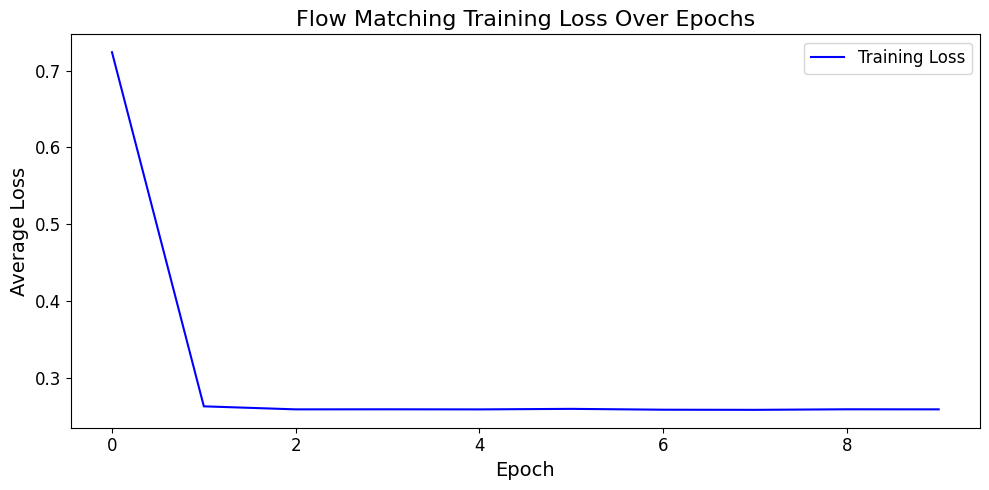

In [66]:
plt.figure(figsize=(10, 5))

plt.plot(loss_history, label='Training Loss', color='blue')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Average Loss', fontsize=14)
plt.title('Flow Matching Training Loss Over Epochs', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

In [79]:
@torch.no_grad()
def rk4_integration(model, x_init, t0=1.0, t1=0.0, steps=80):
    model.eval()
    x = x_init.clone()
    B = x.size(0)

    dt = (t1 - t0) / steps
    t = t0

    for _ in range(steps):
        t_vec = torch.full((B,), t, device=x.device)

        k1 = model(x, t_vec)
        k2 = model(x + 0.5 * dt * k1, t_vec + 0.5 * dt)
        k3 = model(x + 0.5 * dt * k2, t_vec + 0.5 * dt)
        k4 = model(x + dt * k3, t_vec + dt)

        x = x + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
        t = t + dt

    return x

@torch.no_grad()
def sample(model, n=16, steps=80, latent_std=0.1):
    z = torch.randn(n, 1, 64, 64, device=device) * latent_std
    x = rk4_integration(model, z, steps=steps)
    return x

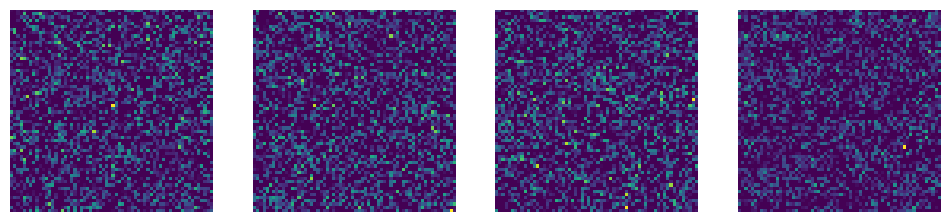

In [80]:
samples = sample(model, n=4, steps=50, latent_std=0.1)

fig, axs = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    img = (samples[i].clamp(-1, 1) + 1) / 2
    axs[i].imshow(img.squeeze().cpu())
    axs[i].axis("off")

plt.show()

In [56]:
n_samples = 10

@torch.no_grad()
def generate_samples(model, n_samples, steps=80, latent_std=0.2):
    model.eval()
    z = torch.randn(n_samples, 1, 64, 64, device=device) * latent_std
    x = rk4_integration(model, z, steps=steps)
    return x.cpu()

# real data
real_imgs = torch.tensor(data_X[:n_samples]).unsqueeze(1)

# generated data
fake_imgs = generate_samples(model, n_samples)

print(real_imgs.shape, fake_imgs.shape)

torch.Size([10, 1, 64, 64]) torch.Size([10, 1, 64, 64])


In [57]:
from skimage.metrics import structural_similarity as ssim

def compute_ssim(real, fake):
    real = real.squeeze(1).numpy()
    fake = fake.squeeze(1).numpy()

    scores = []
    for i in range(len(real)):
        s = ssim(
            real[i],
            fake[i],
            data_range=2.0  # because images are in [-1, 1]
        )
        scores.append(s)

    return np.mean(scores), np.std(scores)

def compute_fid(real, fake):
    """
    real, fake: (N, 1, 64, 64)
    """
    real = real.view(real.size(0), -1).numpy()
    fake = fake.view(fake.size(0), -1).numpy()

    mu_r = real.mean(axis=0)
    mu_f = fake.mean(axis=0)

    cov_r = np.cov(real, rowvar=False)
    cov_f = np.cov(fake, rowvar=False)

    diff = mu_r - mu_f
    covmean = scipy.linalg.sqrtm(cov_r @ cov_f)

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff @ diff + np.trace(cov_r + cov_f - 2 * covmean)
    return float(fid)

ssim_mean, ssim_std = compute_ssim(real_imgs, fake_imgs)
print(f"SSIM: {ssim_mean:.6f} ± {ssim_std:.6f}")

fid_score = compute_fid(real_imgs, fake_imgs)
print(f"FID: {fid_score:.6f}")

SSIM: 0.991452 ± 0.002792
FID: 0.921509


/var/folders/27/76q8rfwn799g95yl3x7jwbnh0000gn/T/ipykernel_3230/3783458403.py:32: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean = scipy.linalg.sqrtm(cov_r @ cov_f)


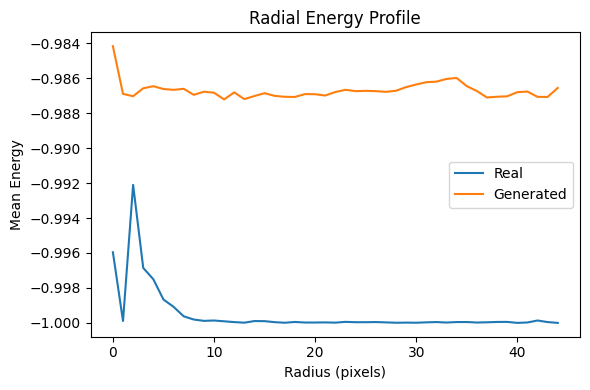

In [58]:
def radial_energy_profile(imgs):
    # imgs: (N, 1, 64, 64)
    N, _, H, W = imgs.shape
    cy, cx = H // 2, W // 2

    yy, xx = torch.meshgrid(
        torch.arange(H), torch.arange(W), indexing="ij"
    )
    r = torch.sqrt((yy - cy)**2 + (xx - cx)**2)
    r = r.to(imgs.device)

    max_r = int(r.max().item())
    profiles = []

    for img in imgs:
        prof = []
        for ri in range(max_r):
            mask = (r >= ri) & (r < ri + 1)
            prof.append(img[0][mask].mean().item())
        profiles.append(prof)

    return np.array(profiles)

def plot_radial_profiles(real, fake):
    rp_real = radial_energy_profile(real)
    rp_fake = radial_energy_profile(fake)

    mean_real = rp_real.mean(axis=0)
    mean_fake = rp_fake.mean(axis=0)

    plt.figure(figsize=(6, 4))
    plt.plot(mean_real, label="Real")
    plt.plot(mean_fake, label="Generated")
    plt.xlabel("Radius (pixels)")
    plt.ylabel("Mean Energy")
    plt.legend()
    plt.title("Radial Energy Profile")
    plt.tight_layout()
    plt.show()

plot_radial_profiles(real_imgs, fake_imgs)

Real energy: mean=-4095.4819, std=0.1331
Fake energy: mean=-4041.5151, std=1.8961


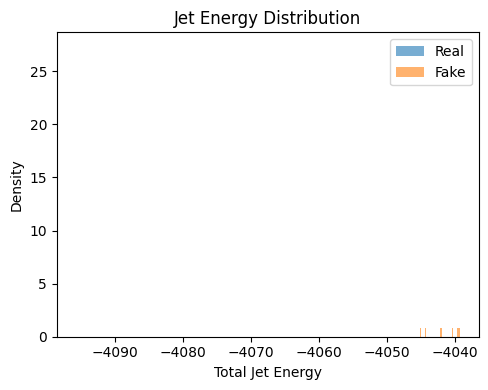

In [59]:
def jet_energy(imgs):
    # imgs: (N, 1, 64, 64)
    return imgs.sum(dim=(1, 2, 3)).numpy()

def compare_energy(real, fake):
    E_real = jet_energy(real)
    E_fake = jet_energy(fake)

    print(f"Real energy: mean={E_real.mean():.4f}, std={E_real.std():.4f}")
    print(f"Fake energy: mean={E_fake.mean():.4f}, std={E_fake.std():.4f}")

    plt.figure(figsize=(5, 4))
    plt.hist(E_real, bins=50, alpha=0.6, label="Real", density=True)
    plt.hist(E_fake, bins=50, alpha=0.6, label="Fake", density=True)
    plt.xlabel("Total Jet Energy")
    plt.ylabel("Density")
    plt.legend()
    plt.title("Jet Energy Distribution")
    plt.tight_layout()
    plt.show()

compare_energy(real_imgs, fake_imgs)

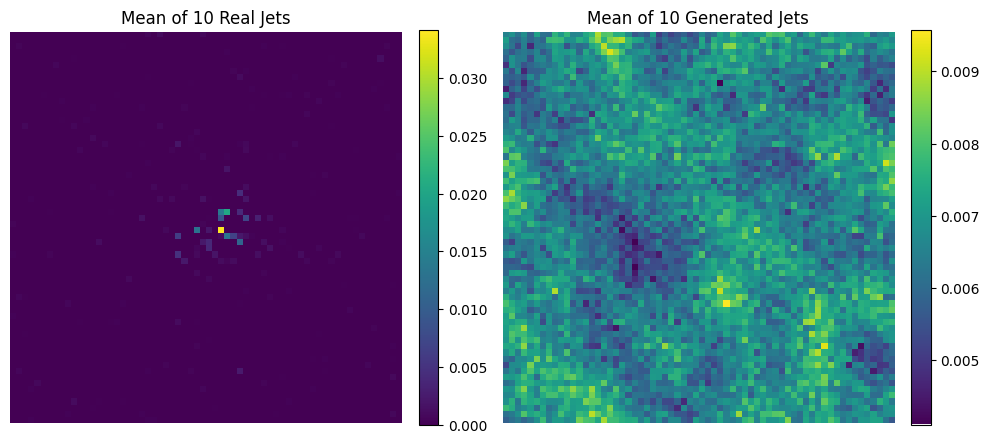

In [61]:
mean_real = real_imgs.mean(dim=0).squeeze()
mean_fake = fake_imgs.mean(dim=0).squeeze()

mean_real_plot = (mean_real + 1) / 2
mean_fake_plot = (mean_fake + 1) / 2

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

im1 = axs[0].imshow(mean_real_plot, cmap='viridis')
axs[0].set_title(f"Mean of {n_samples} Real Jets")
axs[0].axis("off")

im2 = axs[1].imshow(mean_fake_plot, cmap='viridis')
axs[1].set_title(f"Mean of {n_samples} Generated Jets")
axs[1].axis("off")

plt.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)
plt.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()